In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # if not available, use matplotlib.image.imread

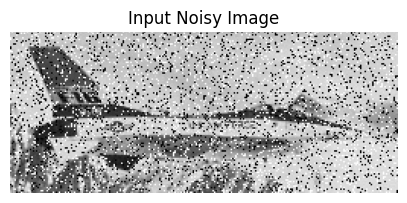

Image size: 106 x 255


In [18]:
# Load image
img_path = "noisy.jpg"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

if img is None:
    raise FileNotFoundError("Image not found!")

# Convert to grayscale if needed
if len(img.shape) == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    img_gray = img.copy()

img_gray = img_gray.astype(np.float64)

# Display input image
plt.figure(figsize=(5,5))
plt.imshow(img_gray, cmap='gray')
plt.title("Input Noisy Image")
plt.axis('off')
plt.show()

H, W = img_gray.shape
print("Image size:", H, "x", W)


In [19]:
def dft2d_non_square(image):
    """
    Optimized 2D DFT for non-square grayscale images.
    image: shape (H, W)
    Returns:
        F: complex spectrum (H x W)
        Ex, Ey: exponential matrices (for inverse DFT)
    """
    H, W = image.shape
    
    # Axes for height
    u = np.arange(H)  # freq rows
    x = np.arange(H)  # spatial rows
    
    # Axes for width
    v = np.arange(W)  # freq cols
    y = np.arange(W)  # spatial cols

    # Ex : (H x H)
    Ex = np.exp(-2j * np.pi * np.outer(u, x) / H)

    # Ey : (W x W)
    Ey = np.exp(-2j * np.pi * np.outer(v, y) / W)

    # F = Ex @ image @ Ey.T
    F = Ex @ image @ Ey.T
    
    return F, Ex, Ey


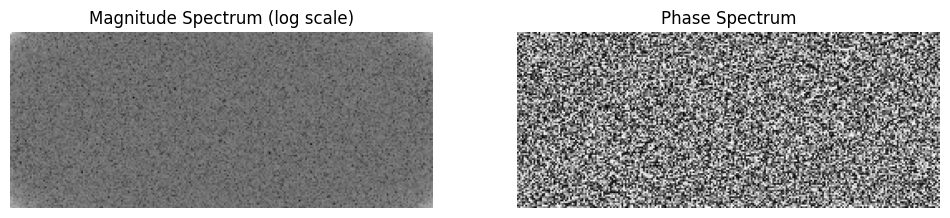

In [20]:
F_complex, Ex, Ey = dft2d_non_square(img_gray)

magnitude = np.abs(F_complex)
phase = np.angle(F_complex)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(np.log1p(magnitude), cmap='gray')
plt.title("Magnitude Spectrum (log scale)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(phase, cmap='gray')
plt.title("Phase Spectrum")
plt.axis('off')

plt.show()


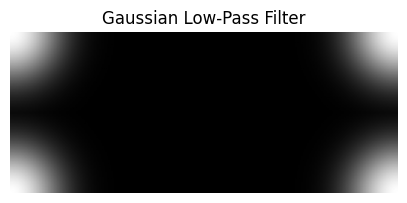

In [21]:
def gaussian_lowpass_filter(H, W, sigma):
    """
    Create a centered Gaussian low-pass filter for size H x W.
    Compatible with unshifted DFT output.
    """
    # Create frequency coordinates (centered)
    u = np.arange(H)
    v = np.arange(W)

    u_shift = np.where(u <= H//2, u, u - H)
    v_shift = np.where(v <= W//2, v, v - W)

    U, V = np.meshgrid(u_shift, v_shift, indexing='ij')
    D2 = U**2 + V**2

    H_filter = np.exp(-D2 / (2 * sigma**2))
    return H_filter

sigma = 20  # adjust later if needed
H_filter = gaussian_lowpass_filter(H, W, sigma)

plt.figure(figsize=(5,5))
plt.imshow(np.log1p(H_filter), cmap='gray')
plt.title("Gaussian Low-Pass Filter")
plt.axis('off')
plt.show()


In [ ]:
F_filtered = F_complex * H_filter

In [ ]:
def idft2d_non_square(F, Ex, Ey):
    """
    Inverse optimized 2D DFT for non-square matrices.
    Uses conjugate-transpose of Ex and Ey.
    """
    H, W = F.shape
    f_rec = (Ex.conj().T @ F @ Ey.conj().T) / (H * W)
    return np.real(f_rec)

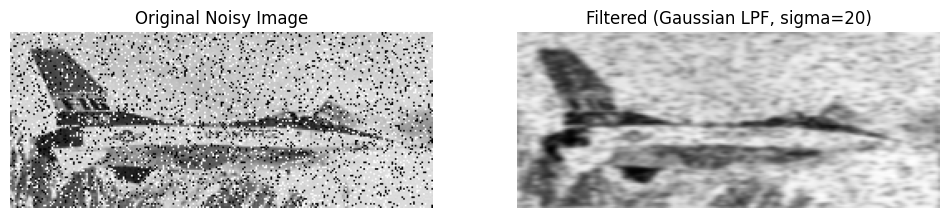

In [25]:
reconstructed = idft2d_non_square(F_filtered, Ex, Ey)
reconstructed_clipped = np.clip(reconstructed, 0, 255)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed_clipped, cmap='gray')
plt.title(f'Filtered (Gaussian LPF, sigma={sigma})')
plt.axis('off')

plt.show()
